<strong>Goal: </strong>
<br>Estimate the return from a direct mailing in order to maximize donation profits.
<br>Subject: Lapsing donors
<br><strong>Models needed:</strong>
<br>- Classifier: Identify which donors are most susceptible to donating (to send or not to send mail)
<br>- Predict donation value: How much will be donated by a specific person/group (how much to invest in sending the mail)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
pproc_df = pd.read_csv('pva97nk_py_preproc_regrssn.csv')
pproc_df.set_index('CONTROLN', inplace=True)
pproc_df.head()

,Unnamed: 0,Donated to In House,Donated to P3,Has Planned Giving Record,AGE,No. of Mail Order Responses,Is a major donor,Median HomeVal (hundreds),Avg HomeVal (hundreds),Median Rent(hundreds),...,Neighbhd/Socio-ec Status_S1,Neighbhd/Socio-ec Status_S2,Neighbhd/Socio-ec Status_S3,Neighbhd/Socio-ec Status_T1,Neighbhd/Socio-ec Status_T2,Neighbhd/Socio-ec Status_T3,Neighbhd/Socio-ec Status_U1,Neighbhd/Socio-ec Status_U2,Neighbhd/Socio-ec Status_U3,Neighbhd/Socio-ec Status_U4
CONTROLN,,,,,,,,,,,,,,,,,,,,,
95515,0,0,0,0,60.000000,0,0,479,635,3,...,0,0,0,0,1,0,0,0,0,0
148535,1,0,0,0,46.000000,16,0,5468,5218,12,...,1,0,0,0,0,0,0,0,0,0
15078,2,0,0,0,69.349251,2,0,497,546,2,...,0,0,0,0,0,0,0,0,0,0
172556,3,0,0,0,70.000000,2,0,1000,1263,2,...,0,0,0,0,0,0,0,0,0,0
7112,4,1,1,0,78.000000,60,0,576,594,4,...,0,1,0,0,0,0,0,0,0,0


##### SAMPLING

In [3]:
pproc_df.shape

(95412, 112)

In [4]:
pproc_df.columns.values

array(['Unnamed: 0', 'Donated to In House', 'Donated to P3',
       'Has Planned Giving Record', 'AGE', 'No. of Mail Order Responses',
       'Is a major donor', 'Median HomeVal (hundreds)',
       'Avg HomeVal (hundreds)', 'Median Rent(hundreds)',
       'Avg Rent(hundreds)', 'Median Hshold Incm (hundreds)',
       'Median Family Incm (hundreds)', 'Avg Hshold Incm (hundreds)',
       'Avg Family Incm (hundreds)', 'Per Capita Income',
       'Total Amt (All Gifts)', 'Total No. (All Gifts)',
       'Total No. (All Gifts:Promos)', 'Amt (Most Recent Gift)',
       '2ndGft-1stGft(months)', 'Avg Amt (All Gifts)',
       'Response (97NK Mail)', 'Amt Donated (97NK Mail)', 'CLUSTER_01',
       'CLUSTER_02', 'CLUSTER_03', 'CLUSTER_04', 'CLUSTER_05',
       'CLUSTER_06', 'CLUSTER_07', 'CLUSTER_08', 'CLUSTER_09',
       'CLUSTER_10', 'CLUSTER_11', 'CLUSTER_12', 'CLUSTER_13',
       'CLUSTER_14', 'CLUSTER_15', 'CLUSTER_16', 'CLUSTER_17',
       'CLUSTER_18', 'CLUSTER_19', 'CLUSTER_20', 'CLUSTER_21

In [5]:
print(pproc_df['Response (97NK Mail)'].value_counts())

print("no response(%)", (1-(pproc_df['Response (97NK Mail)'].sum()/len(pproc_df['Response (97NK Mail)'])))*100)
print("response(%)", (pproc_df['Response (97NK Mail)'].sum()/len(pproc_df['Response (97NK Mail)'])*100))

0    90569
1     4843
Name: Response (97NK Mail), dtype: int64
no response(%) 94.92411855951033
response(%) 5.075881440489666


To achieve a balanced dataset, I will up-sample the response observations to match the number of no-response observations. A balanced dataset will help us measure more accurately the error metrics of our proposed model/s. If we retain the proportions in our sampling, then a model that simply predicts all observations to be no-response would still be about 95% correct. This is what I am trying to avoid. 

<p> To get my samples, I will use SMOTE. But before doing so, I will split my dataset into training and validation sets first, and only apply up-sampling for the training dataset.

In [6]:
#I'm getting an error about my columns having a nan. So to double-check,

pproc_df.columns[pproc_df.isna().any()].tolist()

['AGE']

In [7]:
pproc_df['AGE'].isnull().sum()

1

In [8]:
pproc_df[pproc_df['AGE'].isnull()]

,Unnamed: 0,Donated to In House,Donated to P3,Has Planned Giving Record,AGE,No. of Mail Order Responses,Is a major donor,Median HomeVal (hundreds),Avg HomeVal (hundreds),Median Rent(hundreds),...,Neighbhd/Socio-ec Status_S1,Neighbhd/Socio-ec Status_S2,Neighbhd/Socio-ec Status_S3,Neighbhd/Socio-ec Status_T1,Neighbhd/Socio-ec Status_T2,Neighbhd/Socio-ec Status_T3,Neighbhd/Socio-ec Status_U1,Neighbhd/Socio-ec Status_U2,Neighbhd/Socio-ec Status_U3,Neighbhd/Socio-ec Status_U4
CONTROLN,,,,,,,,,,,,,,,,,,,,,
6050,16716,1,1,0,NaN,0,0,691,776,2,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#So weirdly enough, there is one row with a missing value even if I already supposedly imputed all the nans earlier
#So again,

pproc_df['AGE'].fillna(pproc_df.groupby('Total No. (All Gifts:Promos)')['AGE'].transform('mean'),inplace=True)

In [10]:
pproc_df.columns[pproc_df.isna().any()].tolist()

['AGE']

In [11]:
#It's still there so, in the interest of time, I'll just remove it instead of further troubleshooting it

pproc_df2 = pproc_df[pproc_df.AGE.notnull()]

In [12]:
pproc_df2.columns[pproc_df2.isna().any()].tolist()

[]

In [13]:
pproc_df2[pproc_df2['AGE'].isnull()]

,Unnamed: 0,Donated to In House,Donated to P3,Has Planned Giving Record,AGE,No. of Mail Order Responses,Is a major donor,Median HomeVal (hundreds),Avg HomeVal (hundreds),Median Rent(hundreds),...,Neighbhd/Socio-ec Status_S1,Neighbhd/Socio-ec Status_S2,Neighbhd/Socio-ec Status_S3,Neighbhd/Socio-ec Status_T1,Neighbhd/Socio-ec Status_T2,Neighbhd/Socio-ec Status_T3,Neighbhd/Socio-ec Status_U1,Neighbhd/Socio-ec Status_U2,Neighbhd/Socio-ec Status_U3,Neighbhd/Socio-ec Status_U4
CONTROLN,,,,,,,,,,,,,,,,,,,,,


In [14]:
target_etc_vars = ['Response (97NK Mail)', 'Amt Donated (97NK Mail)','Unnamed: 0']
X = pproc_df2.loc[:, ~pproc_df2.columns.isin(target_etc_vars)]
y = pproc_df2['Response (97NK Mail)']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, random_state=0)

In [16]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train)

In [17]:
df_sm_X_train = pd.DataFrame(data=sm_X_train,columns=X_train.columns)
df_sm_y_train = pd.DataFrame(data=sm_y_train,columns=['Response (97NK Mail)'])

print("total oversampled data: ",len(df_sm_X_train))
print("total no response in oversampled data: ",len(df_sm_y_train[df_sm_y_train['Response (97NK Mail)']==0]))
print("total response in oversampled data: ",len(df_sm_y_train[df_sm_y_train['Response (97NK Mail)']==1]))
print("no response(%): ",len(df_sm_y_train[df_sm_y_train['Response (97NK Mail)']==0])/len(df_sm_X_train))
print("response(%): ",len(df_sm_y_train[df_sm_y_train['Response (97NK Mail)']==1])/len(df_sm_X_train))

total oversampled data:  108746
total no response in oversampled data:  54373
total response in oversampled data:  54373
no response(%):  0.5
response(%):  0.5


##### VARIABLE SELECTION 

Next, I will look at possible redundancies and multicollinearity to ensure independence between input variables in the dataset 

In [18]:
pproc_df.reset_index(inplace=True)
df_index = pd.DataFrame(data=pproc_df, columns=['CONTROLN'])

df_sm_Xy_train = df_sm_X_train.join(df_sm_y_train.join(df_index, lsuffix='_sm_y_train', rsuffix='_controln'),
                                    rsuffix='_sm_y_train', lsuffix='_sm_X_train')

In [19]:
df_sm_Xy_train.set_index('CONTROLN', inplace=True)
len(df_sm_Xy_train.columns.values)

110

In [20]:
#Run correlation matrix

#colormap = plt.cm.RdBu
#plt.figure(figsize=(30,30))
#plt.title('Pearson Correlation of Features', y=1.05, size=15)
#sns.heatmap(df_sm_Xy_train.corr(),linewidths=0.1,vmax=1.0, 
#            square=True, cmap=colormap, linecolor='white', annot=True)

In [21]:
df_sm_Xy_train.columns[0:21]

Index(['Donated to In House', 'Donated to P3', 'Has Planned Giving Record',
       'AGE', 'No. of Mail Order Responses', 'Is a major donor',
       'Median HomeVal (hundreds)', 'Avg HomeVal (hundreds)',
       'Median Rent(hundreds)', 'Avg Rent(hundreds)',
       'Median Hshold Incm (hundreds)', 'Median Family Incm (hundreds)',
       'Avg Hshold Incm (hundreds)', 'Avg Family Incm (hundreds)',
       'Per Capita Income', 'Total Amt (All Gifts)', 'Total No. (All Gifts)',
       'Total No. (All Gifts:Promos)', 'Amt (Most Recent Gift)',
       '2ndGft-1stGft(months)', 'Avg Amt (All Gifts)'],
      dtype='object')

In [22]:
#Calculate Variance Inflation Factor

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_sm_Xy_train_2 = df_sm_Xy_train[df_sm_Xy_train.columns[0:21]] #excludes all the dummified variables
df_sm_Xy_train_2['ones'] = 1 #to avoid the issue here: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_sm_Xy_train_2.values, i) for i in range(df_sm_Xy_train_2.shape[1])]
vif["features"] = df_sm_Xy_train_2.columns

c:\users\monica aguilar\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [23]:
vif

#issue mentioned above does not seem to affect the vif, whether there are ones or none (I ran both)

,VIF Factor,features
0,1.190487,Donated to In House
1,1.033342,Donated to P3
2,1.084891,Has Planned Giving Record
3,1.158587,AGE
4,1.027201,No. of Mail Order Responses
5,1.332693,Is a major donor
6,106.298040,Median HomeVal (hundreds)
7,112.572026,Avg HomeVal (hundreds)
8,13.044557,Median Rent(hundreds)
9,10.516507,Avg Rent(hundreds)


In [24]:
#saving a reference file so I won't need to run again in the future

vif_csv = vif.to_csv('D:\Python Stuff\pva97nk_py_train_vif.csv')

Let's study all non-dummified variables with VIF > 5 and choose which ones to retain:

In [25]:
filtervif = vif[(vif["VIF Factor"] > 5) & (vif["VIF Factor"] != np.inf)]
filtervif

,VIF Factor,features
6,106.298040,Median HomeVal (hundreds)
7,112.572026,Avg HomeVal (hundreds)
8,13.044557,Median Rent(hundreds)
9,10.516507,Avg Rent(hundreds)
10,61.659758,Median Hshold Incm (hundreds)
11,53.983893,Median Family Incm (hundreds)
12,109.040002,Avg Hshold Incm (hundreds)
13,86.597620,Avg Family Incm (hundreds)
14,5.688700,Per Capita Income
16,9.037131,Total No. (All Gifts)


I will retain Median Family Incm (hundreds) and remove Avgs (incl Per Capita Income) to make the dataset more robust to outliers. Both Median HomeVal(hundreds) and Median Rent(hundreds) are approximations of wealth, but Median Family Incm can represent that. Median Family Incm seems to be a better measure of wealth since some households may have more than one family. I will also retain Total No. (All Gifts:Promos) since this ratio captures willingness to respond to promos vs a simple total amount of all gifts.
<p>These further variable selections will be applied to the entire dataset, so that when we test the model later on, it will be comparable and efficient.

In [26]:
#df_y_val = pd.DataFrame(y_val)
#df_Xy_val = X_val.join(df_y_val.join(df_index, lsuffix='_y_val', rsuffix='_controln'),
#                                    rsuffix='_y_val', lsuffix='_X_val')

In [27]:
#df_Xy_val.set_index('CONTROLN', inplace=True)

In [28]:
df_sm_Xy_train_drp = df_sm_Xy_train.drop(['Avg HomeVal (hundreds)','Avg Rent(hundreds)','Median Hshold Incm (hundreds)',
                                          'Avg Hshold Incm (hundreds)','Avg Family Incm (hundreds)',
                                          'Total No. (All Gifts)','Per Capita Income','Median Rent(hundreds)',
                                         'Median HomeVal (hundreds)'], axis=1)
#df_Xy_val_drp = df_Xy_val.drop(['Avg HomeVal (hundreds)','Avg Rent(hundreds)','Avg Hshold Incm (hundreds)',
#                                         'Avg Family Incm (hundreds)','Total No. (All Gifts)'], axis=1)

In [29]:
df_sm_Xy_train_drp.columns.values

array(['Donated to In House', 'Donated to P3',
       'Has Planned Giving Record', 'AGE', 'No. of Mail Order Responses',
       'Is a major donor', 'Median Family Incm (hundreds)',
       'Total Amt (All Gifts)', 'Total No. (All Gifts:Promos)',
       'Amt (Most Recent Gift)', '2ndGft-1stGft(months)',
       'Avg Amt (All Gifts)', 'CLUSTER_01', 'CLUSTER_02', 'CLUSTER_03',
       'CLUSTER_04', 'CLUSTER_05', 'CLUSTER_06', 'CLUSTER_07',
       'CLUSTER_08', 'CLUSTER_09', 'CLUSTER_10', 'CLUSTER_11',
       'CLUSTER_12', 'CLUSTER_13', 'CLUSTER_14', 'CLUSTER_15',
       'CLUSTER_16', 'CLUSTER_17', 'CLUSTER_18', 'CLUSTER_19',
       'CLUSTER_20', 'CLUSTER_21', 'CLUSTER_22', 'CLUSTER_23',
       'CLUSTER_24', 'CLUSTER_25', 'CLUSTER_26', 'CLUSTER_27',
       'CLUSTER_28', 'CLUSTER_29', 'CLUSTER_30', 'CLUSTER_31',
       'CLUSTER_32', 'CLUSTER_33', 'CLUSTER_34', 'CLUSTER_35',
       'CLUSTER_36', 'CLUSTER_37', 'CLUSTER_38', 'CLUSTER_39',
       'CLUSTER_40', 'CLUSTER_41', 'CLUSTER_42', 'CLUSTER_

In [30]:
#But before re-sampling I will re-check the VIF again, just to be sure

df_sm_Xy_train_drp2 = df_sm_Xy_train_drp[df_sm_Xy_train_drp.columns[0:12]]
df_sm_Xy_train_drp2['ones'] = 1

vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(df_sm_Xy_train_drp2.values, i) for i in range(df_sm_Xy_train_drp2.shape[1])]
vif2["features"] = df_sm_Xy_train_drp2.columns
vif2

c:\users\monica aguilar\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,VIF Factor,features
0,1.135595,Donated to In House
1,1.024621,Donated to P3
2,1.083903,Has Planned Giving Record
3,1.123619,AGE
4,1.024062,No. of Mail Order Responses
5,1.318655,Is a major donor
6,1.023531,Median Family Incm (hundreds)
7,2.448033,Total Amt (All Gifts)
8,2.032656,Total No. (All Gifts:Promos)
9,2.755227,Amt (Most Recent Gift)


This time around, the "ones" had an effect on the VIF.

The final columns are now going to be everything in df_sm_Xy_train_drp.columns.values

##### SAMPLING v2

Important note for documentation purposes: My first run of the logistic regression is bad (only 57% accuracy). I will try to re-run without the dummified variables and see if it makes a difference.

In [189]:
X_list = [x for x in df_sm_Xy_train_drp.columns[0:12]]
temp = ['P3 Solicitation Limit_0',
       'P3 Solicitation Limit_00', 'P3 Solicitation Limit_01',
       'P3 Solicitation Limit_02', 'P3 Solicitation Limit_12',
       'In House Solicitation Limit_0', 'In House Solicitation Limit_00',
       'In House Solicitation Limit_01', 'In House Solicitation Limit_02',
       'In House Solicitation Limit_03', 'In House Solicitation Limit_04',
       'In House Solicitation Limit_06', 'In House Solicitation Limit_12',]
temp_X = X_list + temp
temp_X

['Donated to In House',
 'Donated to P3',
 'Has Planned Giving Record',
 'AGE',
 'No. of Mail Order Responses',
 'Is a major donor',
 'Median Family Incm (hundreds)',
 'Total Amt (All Gifts)',
 'Total No. (All Gifts:Promos)',
 'Amt (Most Recent Gift)',
 '2ndGft-1stGft(months)',
 'Avg Amt (All Gifts)',
 'P3 Solicitation Limit_0',
 'P3 Solicitation Limit_00',
 'P3 Solicitation Limit_01',
 'P3 Solicitation Limit_02',
 'P3 Solicitation Limit_12',
 'In House Solicitation Limit_0',
 'In House Solicitation Limit_00',
 'In House Solicitation Limit_01',
 'In House Solicitation Limit_02',
 'In House Solicitation Limit_03',
 'In House Solicitation Limit_04',
 'In House Solicitation Limit_06',
 'In House Solicitation Limit_12']

In [227]:
X_v2 = pproc_df2.loc[:, pproc_df2.columns.isin(postlogit2_cols)] #older version used temp_X instead of postlogit2_cols
y_v2 = pproc_df2['Response (97NK Mail)']

In [240]:
X_v2.columns

Index(['Donated to In House', 'Donated to P3', 'Is a major donor',
       'Total No. (All Gifts:Promos)', 'Amt (Most Recent Gift)'],
      dtype='object')

In [228]:
from sklearn.model_selection import train_test_split

X_v2_train, X_v2_val, y_v2_train, y_v2_val = train_test_split(X_v2, y_v2, test_size = 0.6, random_state=0)

In [229]:
#just testing out the proportions pre-SMOTE

dummydf = pd.DataFrame(y_v2_train)
print(dummydf['Response (97NK Mail)'].value_counts())

0    36267
1     1897
Name: Response (97NK Mail), dtype: int64


In [230]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
sm_X_v2_train, sm_y_v2_train = sm.fit_sample(X_v2_train, y_v2_train)

In [231]:
#just testing out the proportions after-SMOTE

dummydf2 = pd.DataFrame(sm_y_v2_train)
print(dummydf2[0].value_counts())

1    36267
0    36267
Name: 0, dtype: int64


In [232]:
#further sanity check before implementing the model

df_sm_X_v2_train = pd.DataFrame(data=sm_X_v2_train,columns=X_v2_train.columns)
df_sm_y_v2_train = pd.DataFrame(data=sm_y_v2_train,columns=['Response (97NK Mail)'])

print("total oversampled dataset: ",len(df_sm_X_v2_train))
print(df_sm_y_v2_train['Response (97NK Mail)'].value_counts())
print("no response(%): ",len(df_sm_y_v2_train[df_sm_y_v2_train['Response (97NK Mail)']==0])/len(df_sm_X_v2_train))
print("response(%): ",len(df_sm_y_v2_train[df_sm_y_v2_train['Response (97NK Mail)']==1])/len(df_sm_X_v2_train))
print("===")
print("total validation dataset: ",len(X_v2_val))
df_y_v2_val = pd.DataFrame(y_v2_val)
print(df_y_v2_val['Response (97NK Mail)'].value_counts())

total oversampled dataset:  72534
1    36267
0    36267
Name: Response (97NK Mail), dtype: int64
no response(%):  0.5
response(%):  0.5
===
total validation dataset:  57247
0    54302
1     2945
Name: Response (97NK Mail), dtype: int64


In [197]:
#Recursive Feature Elimination

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='ovr',solver='liblinear')
rfe = RFE(logreg, 20)
rfe = rfe.fit(df_sm_X_v2_train, df_sm_y_v2_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True False False  True False False  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[1 1 1 3 4 1 5 6 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [212]:
postrfe_cols = ['Donated to In House','Donated to P3','Has Planned Giving Record','Is a major donor',
                'Total No. (All Gifts:Promos)','Amt (Most Recent Gift)','2ndGft-1stGft(months)','P3 Solicitation Limit_0',
                'P3 Solicitation Limit_00','P3 Solicitation Limit_01','P3 Solicitation Limit_02','P3 Solicitation Limit_12',
                'In House Solicitation Limit_0','In House Solicitation Limit_00','In House Solicitation Limit_01',
                'In House Solicitation Limit_02','In House Solicitation Limit_03','In House Solicitation Limit_04',
                'In House Solicitation Limit_06','In House Solicitation Limit_12']
postrfe_df_sm_X_v2_train = df_sm_Xy_train_drp[postrfe_cols]
df_sm_y_v2_train = df_sm_Xy_train_drp['Response (97NK Mail)']

In [213]:
import statsmodels.api as sm
logit_model=sm.Logit(df_sm_y_v2_train,postrfe_df_sm_X_v2_train)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.678727
         Iterations: 35


c:\users\monica aguilar\appdata\local\programs\python\python37-32\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                       Results: Logit
Model:                      Logit                       Pseudo R-squared:        0.021      
Dependent Variable:         Response (97NK Mail)        AIC:                     147655.6312
Date:                       2019-04-23 15:44            BIC:                     147837.9698
No. Observations:           108746                      Log-Likelihood:          -73809.    
Df Model:                   18                          LL-Null:                 -75377.    
Df Residuals:               108727                      LLR p-value:             0.0000     
Converged:                  0.0000                      Scale:                   1.0000     
No. Iterations:             35.0000                                                         
--------------------------------------------------------------------------------------------
                                Coef.     Std.Err.     z     P>|z|     [0.025       0.975]  
----------------

In [214]:
postlogit_cols = ['Donated to In House','Donated to P3','Has Planned Giving Record','Is a major donor',
                'Total No. (All Gifts:Promos)','Amt (Most Recent Gift)','2ndGft-1stGft(months)']
postlogit_df_sm_X_v2_train = df_sm_Xy_train_drp[postlogit_cols]
df_sm_y_v2_train = df_sm_Xy_train_drp['Response (97NK Mail)']

logit_model=sm.Logit(df_sm_y_v2_train,postlogit_df_sm_X_v2_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.680734
         Iterations 6
                               Results: Logit
Model:                 Logit                  Pseudo R-squared:   0.018      
Dependent Variable:    Response (97NK Mail)   AIC:                148068.1616
Date:                  2019-04-23 15:48       BIC:                148135.3389
No. Observations:      108746                 Log-Likelihood:     -74027.    
Df Model:              6                      LL-Null:            -75377.    
Df Residuals:          108739                 LLR p-value:        0.0000     
Converged:             1.0000                 Scale:              1.0000     
No. Iterations:        6.0000                                                
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------

In [216]:
postlogit2_cols = ['Donated to In House','Donated to P3','Is a major donor',
                'Total No. (All Gifts:Promos)','Amt (Most Recent Gift)']
postlogit2_df_sm_X_v2_train = df_sm_Xy_train_drp[postlogit2_cols]
df_sm_y_v2_train = df_sm_Xy_train_drp['Response (97NK Mail)']

logit_model=sm.Logit(df_sm_y_v2_train,postlogit2_df_sm_X_v2_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.680761
         Iterations 5
                               Results: Logit
Model:                 Logit                  Pseudo R-squared:   0.018      
Dependent Variable:    Response (97NK Mail)   AIC:                148070.0775
Date:                  2019-04-23 15:49       BIC:                148118.0614
No. Observations:      108746                 Log-Likelihood:     -74030.    
Df Model:              4                      LL-Null:            -75377.    
Df Residuals:          108741                 LLR p-value:        0.0000     
Converged:             1.0000                 Scale:              1.0000     
No. Iterations:        5.0000                                                
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------

In [223]:
X_v3 = pproc_df2.loc[:, pproc_df2.columns.isin(postlogit_cols)]
y_v3 = pproc_df2['Response (97NK Mail)']

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X3_train, X3_test, y3_train, y3_test = train_test_split(X_v3, y_v3, test_size=0.6, random_state=0)
columns = X3_train.columns
os_data_X, os_data_y=os.fit_sample(X3_train, y3_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=postlogit_cols)
os_data_y= pd.DataFrame(data=os_data_y,columns=['Response (97NK Mail)'])

print("total oversampled dataset: ",len(os_data_X))
print(os_data_y['Response (97NK Mail)'].value_counts())
print("no response(%): ",len(os_data_y[os_data_y['Response (97NK Mail)']==0])/len(os_data_X))
print("response(%): ",len(os_data_y[os_data_y['Response (97NK Mail)']==1])/len(os_data_X))
print("===")
print("total validation dataset: ",len(X3_test))
df_y3_test = pd.DataFrame(y3_test)
print(df_y3_test['Response (97NK Mail)'].value_counts())

total oversampled dataset:  72534
1    36267
0    36267
Name: Response (97NK Mail), dtype: int64
no response(%):  0.5
response(%):  0.5
===
total validation dataset:  57247
0    54302
1     2945
Name: Response (97NK Mail), dtype: int64


In [224]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(multi_class='ovr',solver='liblinear')
logreg.fit(X3_train, y3_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

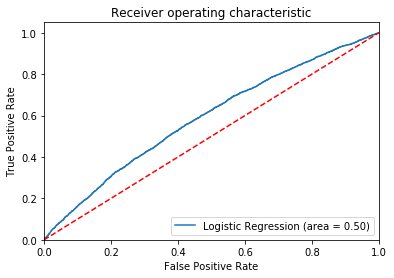

In [225]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc2 = roc_auc_score(y3_test, logreg.predict(X3_test))
fpr2, tpr2, thresholds2 = roc_curve(y3_test, logreg.predict_proba(X3_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [226]:
from sklearn.metrics import confusion_matrix

y_pred2 = logreg.predict(X3_test)

confusion_matrix2 = confusion_matrix(y3_test, y_pred2)
print(confusion_matrix2)
print("misclassification rate: ", (confusion_matrix2[0][1]+confusion_matrix2[1][0])/confusion_matrix2.sum())
print("sensitivity: ",confusion_matrix2[0][0]/(confusion_matrix2[0][0]+confusion_matrix2[0][1]))
print("specificity: ",confusion_matrix2[1][1]/(confusion_matrix2[1][1]+confusion_matrix2[1][0]))

[[54302     0]
 [ 2945     0]]
misclassification rate:  0.05144374377696648
sensitivity:  1.0
specificity:  0.0


##### LOGISTIC REGRESSION IMPLEMENTATION

In [233]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(multi_class='ovr',solver='liblinear')
logreg.fit(sm_X_v2_train, sm_y_v2_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [234]:
y_pred = logreg.predict(X_v2_val)
print('Accuracy of logistic regression classifier on test set: {: }'.format(logreg.score(X_v2_val, y_v2_val)))

Accuracy of logistic regression classifier on test set:  0.6245567453316331


In [235]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_v2_val, y_pred)
print(confusion_matrix)

[[34276 20026]
 [ 1467  1478]]


In [236]:
confusion_matrix.sum()

57247

In [237]:
print("misclassification rate: ", (confusion_matrix[0][1]+confusion_matrix[1][0])/confusion_matrix.sum())
print("sensitivity: ",confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1]))
print("specificity: ",confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0]))

misclassification rate:  0.3754432546683669
sensitivity:  0.6312106368089573
specificity:  0.5018675721561969


In [238]:
from sklearn.metrics import classification_report

print(classification_report(y_v2_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.63      0.76     54302
           1       0.07      0.50      0.12      2945

   micro avg       0.62      0.62      0.62     57247
   macro avg       0.51      0.57      0.44     57247
weighted avg       0.91      0.62      0.73     57247



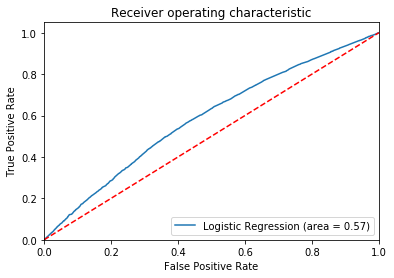

In [239]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_v2_val, logreg.predict(X_v2_val))
fpr, tpr, thresholds = roc_curve(y_v2_val, logreg.predict_proba(X_v2_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Verdict:
- my overall misclassification rate is better vs my SAS implementation
- my true positive rate is a bit better (i.e., my model can better predict actual responders)
- my true negative rate is worse (i.e., my model is worse in identifying actual non-responders)
- my model is worse off by 0.04 or 4 percentage pts in terms of AUROC vs the SAS implementation (i.e., my model performs worse in terms of clearly segregating the two classes)
- A mammogram is another example of high-sensitivity / low specificity test. In general, high sensitivity tests have low specificity. In other words, they are good for catching actual cases of the disease but they also come with a fairly high rate of false positives. (https://www.statisticshowto.datasciencecentral.com/sensitivity-vs-specificity-statistics/)
- It may appear that for predicting rare events like diseases, high-sensitivity / low specificity models are also used.
- In our case, however, the model would only be desirable if the amount of donation is predicted to outweigh the cost of producing and sending the cards.
- <strong>NEXT STEP:</strong> Forecast amount of donation.

In [305]:
lst_y_pred = [x for x in y_pred]
lst_y_v2_val = 
X_v2_val['y_pred'] = lst_y_pred

c:\users\monica aguilar\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [306]:
X_v2_val.drop(['temp'], axis=1, inplace=True)

KeyError: "['temp'] not found in axis"

In [308]:
X_v2_val.head()

,CONTROLN,Donated to In House,Donated to P3,Is a major donor,Total No. (All Gifts:Promos),Amt (Most Recent Gift),y_pred
0,11148,1,0,0,12,10.0,1
1,68233,0,0,0,10,15.0,1
2,159109,0,0,0,5,25.0,0
3,30849,0,0,0,12,10.0,1
4,160343,0,0,0,1,20.0,0


In [312]:
amt_df = pd.DataFrame(pproc_df2['Avg Amt (All Gifts)'])
amt_df.reset_index(inplace=True)
amt_df.head()

,CONTROLN,Avg Amt (All Gifts)
0,95515,7.741935
1,148535,15.666667
2,15078,7.481481
3,172556,6.812500
4,7112,6.864865


In [332]:
df_y_v2_val = y_v2_val.to_frame()
type(df_y_v2_val)

pandas.core.frame.DataFrame

In [333]:
df_pred_amt = X_v2_val.merge(amt_df,on='CONTROLN').merge(df_y_v2_val,on='CONTROLN')
df_pred_amt.head()

,CONTROLN,Donated to In House,Donated to P3,Is a major donor,Total No. (All Gifts:Promos),Amt (Most Recent Gift),y_pred,Avg Amt (All Gifts),Response (97NK Mail)
0,11148,1,0,0,12,10.0,1,10.921053,0
1,68233,0,0,0,10,15.0,1,7.866667,0
2,159109,0,0,0,5,25.0,0,18.125000,0
3,30849,0,0,0,12,10.0,1,6.800000,0
4,160343,0,0,0,1,20.0,0,20.000000,0


In [337]:
sum_by_ypred = df_pred_amt.groupby("y_pred")["Avg Amt (All Gifts)"].sum()
sum_by_ypred

y_pred
0    569916.862552
1    192286.301145
Name: Avg Amt (All Gifts), dtype: float64

In [339]:
sum_by_yactual = df_pred_amt.groupby("Response (97NK Mail)")["Avg Amt (All Gifts)"].sum()
sum_by_yactual

Response (97NK Mail)
0    727234.960236
1     34968.203461
Name: Avg Amt (All Gifts), dtype: float64

In [340]:
sum_by_yactual[1]-sum_by_ypred[1]

-157318.0976837461

In [343]:
count_by_yactual = df_pred_amt.groupby("Response (97NK Mail)")["Avg Amt (All Gifts)"].count()
count_by_yactual

Response (97NK Mail)
0    54302
1     2945
Name: Avg Amt (All Gifts), dtype: int64

In [344]:
sum_by_yactual[1]/count_by_yactual[1]

11.873753297520038


## Testing out Random Forest

In [171]:
from sklearn.ensemble import RandomForestClassifier

# random forest model creation
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(sm_X_v2_train, sm_y_v2_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [186]:
# predictions
rfc_predict = rfc.predict(X_v2_val)


print('Accuracy of logistic regression classifier on test set: {: }'.format(logreg.score(X_v2_val, y_v2_val)))
print('Accuracy of random forest classifier on test set: {: }'.format(metrics.accuracy_score(y_v2_val, rfc_predict)))

Accuracy of logistic regression classifier on test set:  0.6064073226544623
Accuracy of random forest classifier on test set:  0.9422327807570703


In [182]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

print("=== Confusion Matrix ===")
confusion_matrix = confusion_matrix(y_v2_val, rfc_predict)
print(confusion_matrix)
print('\n')
print("=== Classification Report ===")
print(classification_report(y_v2_val, rfc_predict))
print('\n')

=== Confusion Matrix ===
[[53911   391]
 [ 2916    29]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     54302
           1       0.07      0.01      0.02      2945

   micro avg       0.94      0.94      0.94     57247
   macro avg       0.51      0.50      0.49     57247
weighted avg       0.90      0.94      0.92     57247





In [183]:
print("misclassification rate: ", (confusion_matrix[0][1]+confusion_matrix[1][0])/confusion_matrix.sum())
print("sensitivity: ",confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1]))
print("specificity: ",confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0]))

misclassification rate:  0.05776721924292976
sensitivity:  0.9927995285624839
specificity:  0.009847198641765705
